In [38]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random

def init_network(key, input_dim=10, hidden_dim=32, output_dim=1):
    """Initialize a 3-layer network with ~1k parameters"""
    keys = random.split(key, 6)
    
    # Layer 1: input_dim -> hidden_dim
    W1 = random.normal(keys[0], (input_dim, hidden_dim)) * 0.1
    b1 = jnp.zeros(hidden_dim)
    
    # Layer 2: hidden_dim -> hidden_dim  
    W2 = random.normal(keys[2], (hidden_dim, hidden_dim)) * 0.1
    b2 = jnp.zeros(hidden_dim)
    
    # Layer 3: hidden_dim -> output_dim
    W3 = random.normal(keys[4], (hidden_dim, output_dim)) * 0.1
    b3 = jnp.zeros(output_dim)
    
    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Count parameters
    total_params = sum(p.size for p in jax.tree.leaves(params))
    print(f"Total parameters: {total_params}")
    
    return params

def forward(params, x):
    """Forward pass through the network"""
    # Layer 1
    h1 = jnp.tanh(jnp.dot(x, params['W1']) + params['b1'])
    
    # Layer 2  
    h2 = jnp.tanh(jnp.dot(h1, params['W2']) + params['b2'])
    
    # Layer 3 (output)
    logits = jnp.dot(h2, params['W3']) + params['b3']
    
    return logits.squeeze()

def binary_cross_entropy_loss(params, x, y):
    """Binary cross-entropy loss"""
    logits = forward(params, x)
    # Sigmoid + BCE in numerically stable way
    return jnp.mean(jnp.maximum(logits, 0) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits))))

def accuracy(params, x, y):
    """Calculate accuracy"""
    logits = forward(params, x)
    predictions = (logits > 0).astype(jnp.float32)
    return jnp.mean(predictions == y)

@jit
def update_step(params, x, y, learning_rate=0.01):
    """Single gradient descent step"""
    loss_val, grads = jax.value_and_grad(binary_cross_entropy_loss)(params, x, y)
    
    # Update parameters
    updated_params = jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    
    return updated_params, loss_val

def generate_data(key, n_samples=1000, input_dim=10):
    """Generate synthetic binary classification data"""
    keys = random.split(key, 3)

    X_bg = random.normal(keys[0], (int(n_samples/2), input_dim)) * 0.1
    X_sig = random.normal(keys[1], (int(n_samples/2), input_dim)) * 0.1 + 5.0
    
    X = jnp.vstack((X_bg, X_sig))
    y = jnp.concatenate((jnp.zeros(int(n_samples/2)), jnp.ones(int(n_samples/2))))
    
    return X, y

# Training loop
def train_network():
    key = random.PRNGKey(42)
    keys = random.split(key, 3)
    
    # Generate data
    X_train, y_train = generate_data(keys[0], n_samples=800)
    X_test, y_test = generate_data(keys[1], n_samples=200)
    
    # Initialize network
    params = init_network(keys[2], input_dim=X_train.shape[1])
    
    # Training
    learning_rate = 0.01
    n_epochs = 1000
    
    for epoch in range(n_epochs):
        params, loss = update_step(params, X_train, y_train, learning_rate)
        
        if epoch % 100 == 0:
            train_acc = accuracy(params, X_train, y_train)
            test_acc = accuracy(params, X_test, y_test)
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")
    
    return params, X_test, y_test

# Saving and loading functions
import pickle
import numpy as np

def save_model_pickle(params, filepath):
    """Save model parameters using pickle"""
    # Convert JAX arrays to numpy for serialization
    numpy_params = jax.tree.map(np.array, params)
    with open(filepath, 'wb') as f:
        pickle.dump(numpy_params, f)
    print(f"Model saved to {filepath}")

def load_model_pickle(filepath):
    """Load model parameters from pickle file"""
    with open(filepath, 'rb') as f:
        numpy_params = pickle.load(f)
    # Convert back to JAX arrays
    params = jax.tree.map(jnp.array, numpy_params)
    return params


# Run training
if __name__ == "__main__":
    trained_params, X_test, y_test = train_network()
    
    # Final evaluation
    final_accuracy = accuracy(trained_params, X_test, y_test)
    print(f"\nFinal test accuracy: {final_accuracy:.4f}")
    
    # Save the model using different methods
    print("\nSaving model...")
    
    # Method 1: Simple pickle
    save_model_pickle(trained_params, "model.pkl")
    
    # Demonstrate loading
    print("\nLoading model...")
    loaded_params = load_model_pickle("model.pkl")


Total parameters: 1441
Epoch 0: Loss = 0.6525, Train Acc = 0.7825, Test Acc = 0.7500
Epoch 100: Loss = 0.3768, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 200: Loss = 0.2430, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 300: Loss = 0.1511, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 400: Loss = 0.0956, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 500: Loss = 0.0641, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 600: Loss = 0.0457, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 700: Loss = 0.0343, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 800: Loss = 0.0269, Train Acc = 1.0000, Test Acc = 1.0000
Epoch 900: Loss = 0.0218, Train Acc = 1.0000, Test Acc = 1.0000

Final test accuracy: 1.0000

Saving model...
Model saved to model.pkl

Loading model...


In [14]:
# load the data from the uproot files
import uproot
import warnings
import numpy as np
import awkward as ak
import vector
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

NanoAODSchema.warn_missing_crossrefs = False
warnings.filterwarnings("ignore", category=FutureWarning, module="coffea.*")

In [149]:
# variables into memory (takes ~1min)
file_dict = {
    # "wjets": "preproc_uproot/z-prime-ttbar-data/wjets__nominal/file__0/part0.root",
    # "ttbar_had": "preproc_uproot/z-prime-ttbar-data/ttbar_had__nominal/file__0/part0.root",
    # "ttbar_lep": "preproc_uproot/z-prime-ttbar-data/ttbar_lep__nominal/file__0/part0.root",
    # "ttbar_semilep": "preproc_uproot/z-prime-ttbar-data/ttbar_semilep__nominal/file__0/part0.root",
    "signal": "preproc_uproot/z-prime-ttbar-data/signal__nominal/file__0/part0.root",
}

# data = {}
for proc, file_path in file_dict.items():
    print(f"Processing {proc}...")
    data[proc] = {}
    events = NanoEventsFactory.from_root(
        f"{file_path}:Events", schemaclass=NanoAODSchema, delayed=False,
    ).events()

    print(events.Jet.fields)

    # require at least 2 jets and exaclty 1 muon
    events = events[ak.num(events.Jet, axis=1) >= 2]
    events = events[ak.num(events.Muon, axis=1) == 1]

    jets, muons = events.Jet, events.Muon

    # number of jets
    data[proc]["n_jet"] = ak.num(jets, axis=1).to_numpy()

    # leading and subleading jet mass
    data[proc]["leading_jet_mass"] = jets.mass[:, 0].to_numpy()
    data[proc]["subleading_jet_mass"] = jets.mass[:, 1].to_numpy()

    # scalar sum ST
    data[proc]["st"] = (
        ak.sum(jets.pt, axis=1) + ak.sum(muons.pt, axis=1)
    ).to_numpy()

    # leading and subleading jet b-tag score
    data[proc]["leading_jet_btag_score"] = jets.btagDeepB[:, 0].to_numpy()
    data[proc]["subleading_jet_btag_score"] = jets.btagDeepB[:, 1].to_numpy()

    # Sphericity tensor (only zz component)
    denominator = ak.sum(jets.px**2 + jets.py**2 + jets.pz**2, axis=1)
    S_zz = ak.sum(jets.pz * jets.pz, axis=1) / denominator
    data[proc]["S_zz"] = S_zz.to_numpy()

    # deltaR between muon and closest jet
    muon_in_pair, jet_in_pair = ak.unzip(ak.cartesian([muons, jets]))
    delta_r = muon_in_pair.deltaR(jet_in_pair)
    min_delta_r = ak.min(delta_r, axis=1)
    data[proc]["deltaR"] = min_delta_r.to_numpy()

    # transverse momentum of the muon w.r.t. the axis of the nearest jet (pt_rel)
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    angle = muons.deltaangle(jet_in_pair[min_delta_r_indices])
    data[proc]["pt_rel"] = (muons.p * np.sin(angle)).to_numpy().flatten()

    # deltaR between muon and closest jet times the jet pt
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    closest_jet_pt = jet_in_pair.pt[min_delta_r_indices]
    data[proc]["deltaR_times_pt"] = (min_delta_r * closest_jet_pt).to_numpy().flatten()


Processing signal...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']


In [150]:
cd6 = {
    "blue": "#5790fc",
    "orange": "#f89c20",
    "red": "#e42536",
    "violet": "#964a8b",
    "gray": "#9c9ca1",
    "purple": "#7a21dd",
}

process_color_dict = {
    "wjets": cd6["blue"],
    "ttbar_had": cd6["red"],
    "ttbar_lep": cd6["orange"],
    "ttbar_semilep": cd6["purple"],
    "ttbar": cd6["red"],
    "signal": cd6["violet"],
}

model_color_dict = {}

In [17]:
processes = list(data.keys())
variables = list(data[processes[0]].keys())

data["ttbar"] = {}
for var in variables:
    data["ttbar"][var] = np.concatenate([data[p][var] for p in ["ttbar_had", "ttbar_lep", "ttbar_semilep"]])


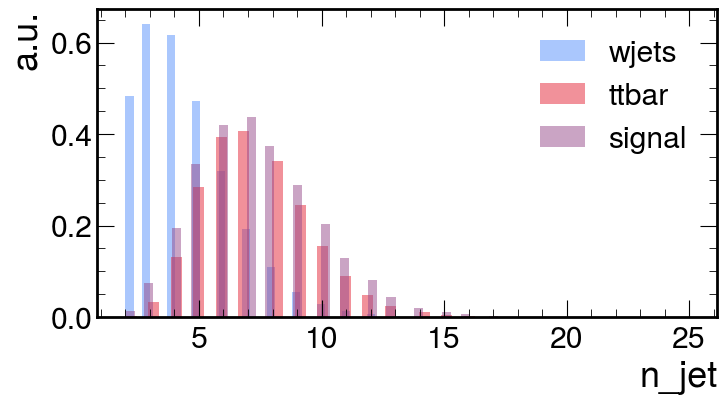

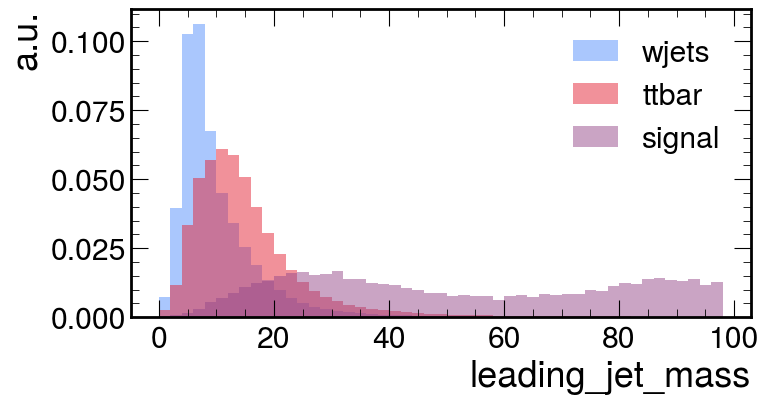

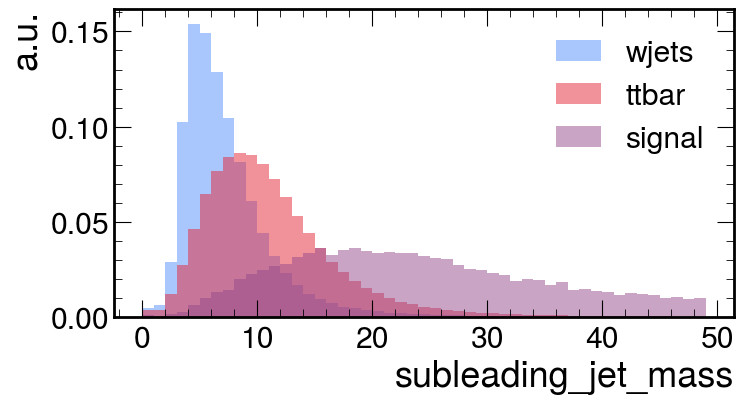

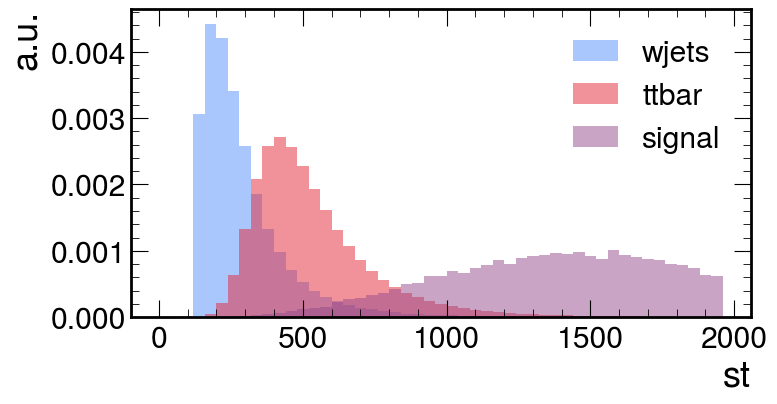

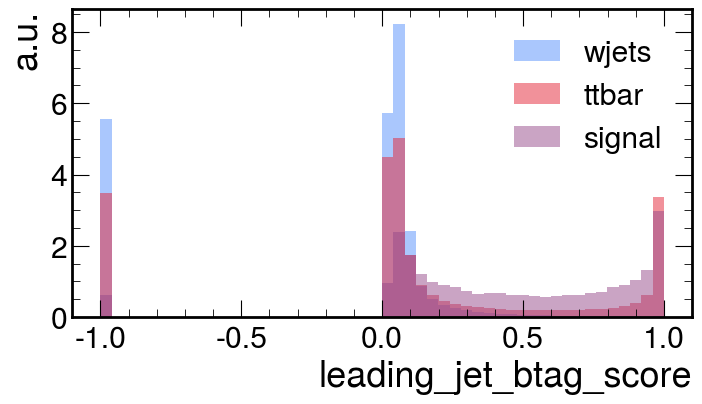

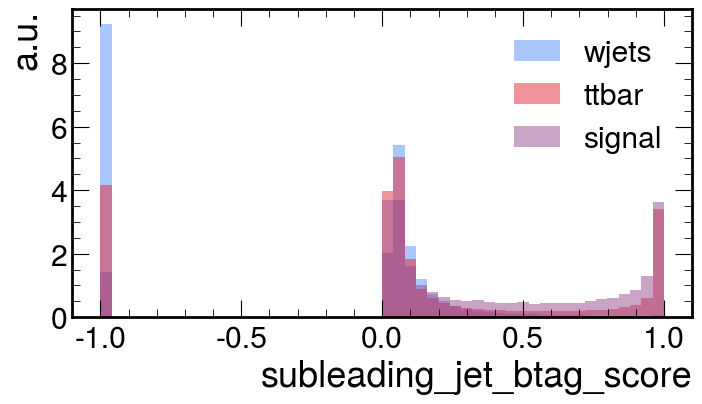

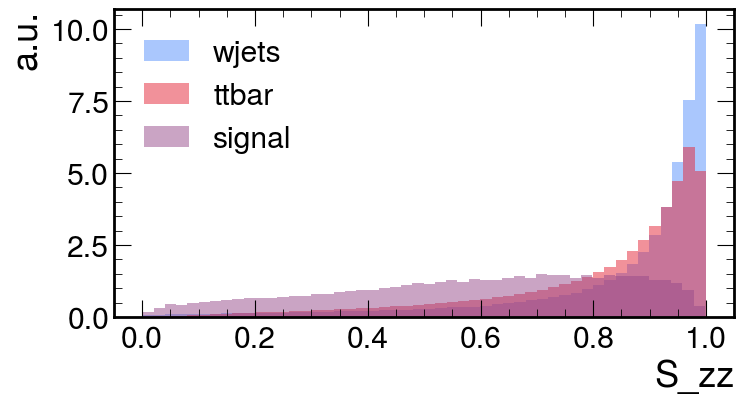

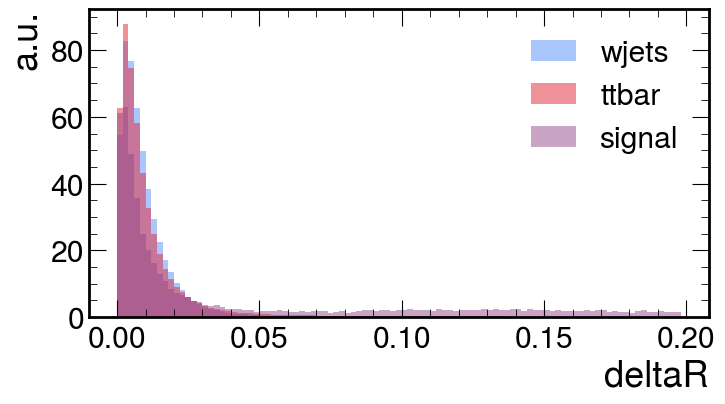

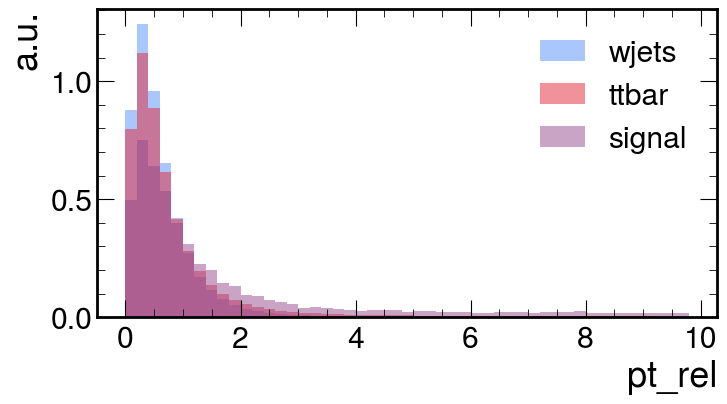

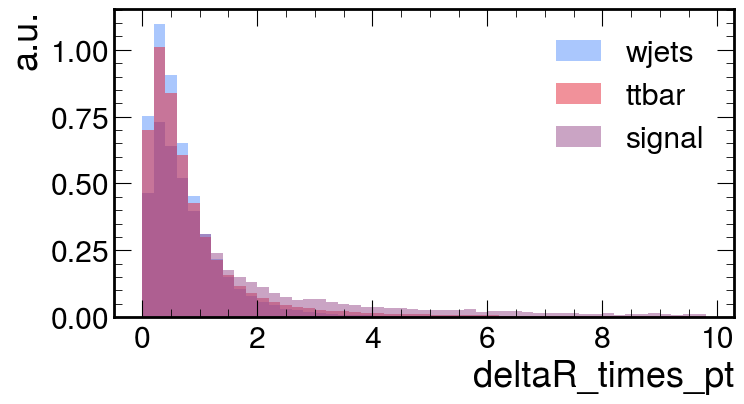

In [151]:
import importlib
from utils import drawing
importlib.reload(drawing)
draw = drawing.Draw(output_dir="output/plots/", interactive=True)
draw.process_color_dict = process_color_dict

binnings = {
    "n_jet": 50,
    "leading_jet_mass": range(0, 100, 2),
    "subleading_jet_mass": range(0, 50, 1),
    "st": range(0, 2000, 40),
    "leading_jet_btag_score": 50,
    "subleading_jet_btag_score": 50,
    "S_zz": 50,
    "deltaR": np.arange(0, 0.2, 0.002),
    "pt_rel": np.arange(0, 10, 0.2),
    "deltaR_times_pt": np.arange(0, 10, 0.2),
}

for var, bins in binnings.items():
    draw.plot_simple_hist(
        {p: data[p][var] for p in ["wjets", "ttbar", "signal"]},
        bins=bins,
        x_label=var,
    )



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

var_scale_dict = {
    # "st": 1./500.,
    "n_jet": 1./10.,
    # "leading_jet_btag_score": 1.,
    "leading_jet_mass": 1./20.,
    "subleading_jet_mass": 1./10.,
    # "S_zz": 1.,
    # "deltaR": 20.,
}

# my_vars = ["st", "leading_jet_mass", "subleading_jet_mass", "S_zz", "deltaR", "pt_rel", "deltaR_times_pt"]

# X_wjets = np.column_stack([data["wjets"][var] for var in my_vars]).astype(float)
# X_ttbar = np.column_stack([data["ttbar"][var] for var in my_vars]).astype(float)

X_wjets = np.column_stack([data["wjets"][v]*s for v, s in var_scale_dict.items()]).astype(float)
X_ttbar = np.column_stack([data["ttbar"][v]*s for v, s in var_scale_dict.items()]).astype(float)
X_signal = np.column_stack([data["signal"][v]*s for v, s in var_scale_dict.items()]).astype(float)

y_wjets = np.zeros_like(data["wjets"]["n_jet"], dtype=float)
y_ttbar = np.ones_like(data["ttbar"]["n_jet"], dtype=float)

X = np.concatenate([X_wjets, X_ttbar[:len(X_wjets)]], axis=0)  # tiny model, so we can omit most ttbar events to create a balanced dataset
y = np.concatenate([y_wjets, y_ttbar[:len(y_wjets)]], axis=0)

X = jnp.array(X, dtype=jnp.float32)
y = jnp.array(y, dtype=jnp.float32)
#  class_weights = {0: 1.0, 1: np.sum(y==0) / np.sum(y==1)}  # (also tested with imbalanced datasets and sample weights: minimal gain. hence omitted)

# X = StandardScaler().fit_transform(X) # works quite well w/o scaling.

# shuffele and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


In [ ]:
for i in X.shape[1]:
    draw.plot_simple_hist(
        {p: data[p][var] for p in ["wjets", "ttbar"]},
        bins=bins,
        x_label=var,
    )


In [68]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"{y_train.sum() / len(y_train) * 100:.2f}% of training samples are signal (ttbar)")
print(f"{y_test.sum() / len(y_test) * 100:.2f}% of training samples are signal (ttbar)")


X_train shape: (335972, 3), y_train shape: (335972,)
50.05% of training samples are signal (ttbar)
49.78% of training samples are signal (ttbar)


In [98]:
key = random.PRNGKey(42)
keys = random.split(key, 3)

# Initialize network
params = init_network(keys[2], input_dim=X_train.shape[1], hidden_dim=16)

# print(f"Initialized parameters: {params}")

for key, value in params.items():
    print(f"{key}: {value.shape}")


Total parameters: 353
W1: (3, 16)
b1: (16,)
W2: (16, 16)
b2: (16,)
W3: (16, 1)
b3: (1,)


In [122]:
# Training
learning_rate = 0.01
n_epochs = 1000

history = {
    "loss": [],
    "train_acc": [],
    "test_acc": []
}

for epoch in range(n_epochs):
    params, loss = update_step(params, X_train, y_train, learning_rate)
    history["loss"].append(loss)
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)
    
    if epoch % 100 == 0:
        train_acc = accuracy(params, X_train, y_train)
        test_acc = accuracy(params, X_test, y_test)
        print(f"Epoch {epoch}: Loss = {loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

# Final evaluation
final_accuracy = accuracy(params, X_test, y_test)
print(f"\nFinal test accuracy: {final_accuracy:.4f}")


Epoch 0: Loss = 0.6486, Train Acc = 0.7388, Test Acc = 0.7354
Epoch 100: Loss = 0.6390, Train Acc = 0.7583, Test Acc = 0.7554
Epoch 200: Loss = 0.6278, Train Acc = 0.7742, Test Acc = 0.7703
Epoch 300: Loss = 0.6150, Train Acc = 0.7863, Test Acc = 0.7820
Epoch 400: Loss = 0.6004, Train Acc = 0.7949, Test Acc = 0.7913
Epoch 500: Loss = 0.5842, Train Acc = 0.8000, Test Acc = 0.7972
Epoch 600: Loss = 0.5667, Train Acc = 0.8030, Test Acc = 0.8002
Epoch 700: Loss = 0.5485, Train Acc = 0.8048, Test Acc = 0.8029
Epoch 800: Loss = 0.5301, Train Acc = 0.8064, Test Acc = 0.8040
Epoch 900: Loss = 0.5125, Train Acc = 0.8077, Test Acc = 0.8056

Final test accuracy: 0.8071


In [123]:
for key, value in params.items():
    print(f"{key}: {value.shape}")

# Final evaluation
final_accuracy = accuracy(params, X_test, y_test)
print(f"\nFinal test accuracy: {final_accuracy:.4f}")


W1: (3, 16)
W2: (16, 16)
W3: (16, 1)
b1: (16,)
b2: (16,)
b3: (1,)

Final test accuracy: 0.8071


In [124]:
# Save the model using different methods
print("\nSaving model...")

# Method 1: Simple pickle
save_model_pickle(params, "model.pkl")



Saving model...
Model saved to model.pkl


In [ ]:
for key, value in params.items():
    print(f"{key}: {value.shape}")

print(f"{X_test.shape=}")
scores = forward(params, X_test)


W1: (3, 16)
W2: (16, 16)
W3: (16, 1)
b1: (16,)
b2: (16,)
b3: (1,)
X_test.shape=(83994, 3)


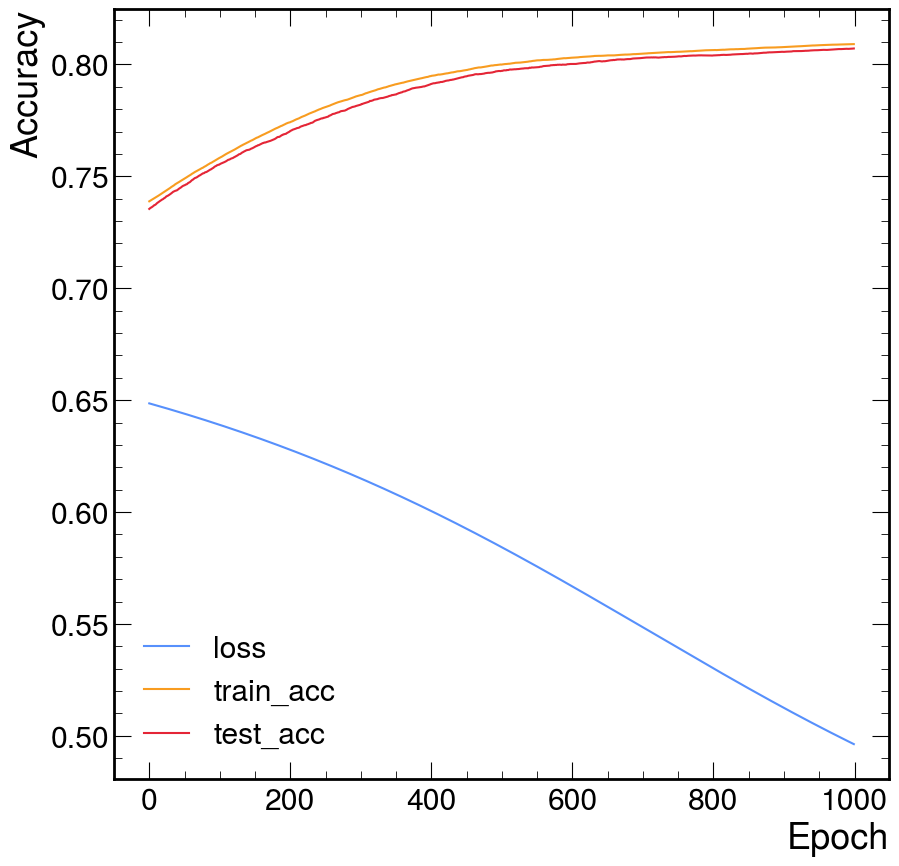

In [125]:
import matplotlib.pyplot as plt
plt.plot(history["loss"], label="loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
logits = forward(params, x)
predictions = (logits > 0).astype(jnp.float32)
return jnp.mean(predictions == y)


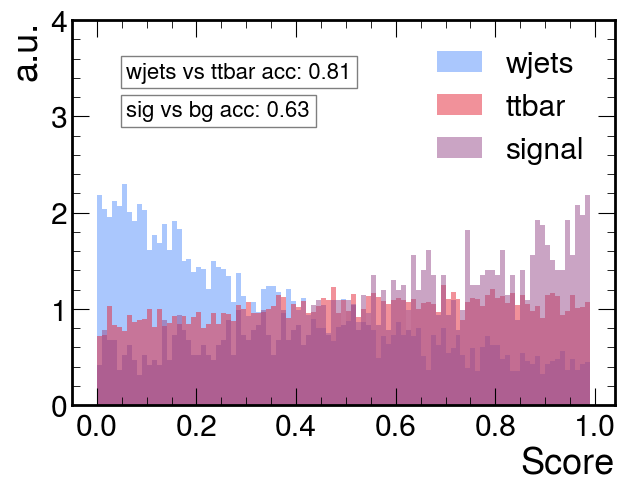

In [168]:
params = load_model_pickle("model.pkl")
wjets_score = forward(params, X_test[y_test==0])
ttbar_score =  forward(params, X_test[y_test==1])
signal_score = forward(params, X_signal)
test_acc = accuracy(params, X_test, y_test)

signal_acc = accuracy(
    params,
    np.concatenate([X_signal, X_test]),
    np.concatenate([np.ones(len(X_signal)), np.zeros(len(X_test))]),
)

bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 5))
plt.hist(
    wjets_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="wjets",
    color=process_color_dict["wjets"],
    alpha=0.5,
    density=True,
)
plt.hist(
    ttbar_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="ttbar",
    color=process_color_dict["ttbar"],
    alpha=0.5,
    density=True,
)
plt.hist(
    signal_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="signal",
    color=process_color_dict["signal"],
    alpha=0.5,
    density=True,
)
plt.xlabel("Score")
plt.ylabel("a.u.")
plt.gca().set_ylim(0, 4)
plt.legend()
plt.text(0.1, 0.85, f"wjets vs ttbar acc: {test_acc:.2f}", transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.1, 0.75, f"sig vs bg acc: {signal_acc:.2f}", transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.show()


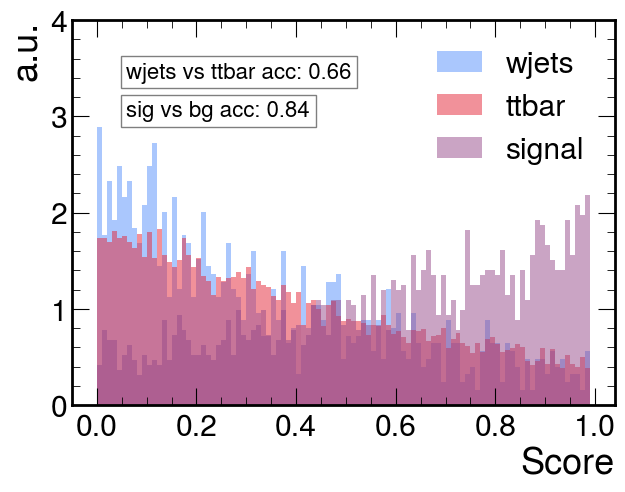

In [169]:
params = load_model_pickle("model-after-optimization.pkl")
wjets_score = forward(params, X_test[y_test==0])
ttbar_score =  forward(params, X_test[y_test==1])
test_acc = accuracy(params, X_test, y_test)

signal_acc = accuracy(
    params,
    np.concatenate([X_signal, X_test]),
    np.concatenate([np.ones(len(X_signal)), np.zeros(len(X_test))]),
)


bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 5))
plt.hist(
    wjets_score,
    bins=bins,
    label="wjets",
    color=process_color_dict["wjets"],
    alpha=0.5,
    density=True,
)
plt.hist(
    ttbar_score,
    bins=bins,
    label="ttbar",
    color=process_color_dict["ttbar"],
    alpha=0.5,
    density=True,
)
plt.hist(
    signal_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=bins,
    label="signal",
    color=process_color_dict["signal"],
    alpha=0.5,
    density=True,
)
plt.xlabel("Score")
plt.ylabel("a.u.")
# set ylim
plt.gca().set_ylim(0, 4)
plt.legend()
plt.text(0.1, 0.85, f"wjets vs ttbar acc: {test_acc:.2f}", transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.1, 0.75, f"sig vs bg acc: {signal_acc:.2f}", transform=plt.gca().transAxes, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.show()
